In [ ]:
!pip install stable-baselines3
!pip install -U pyyaml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 5.1 MB/s 
     |████████████████████████████████| 1.5 MB 51.8 MB/s 
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616827 sha256=f674929db01c5b5d60d2de0b8500f1c461c74b7200f098713a2fd984f035d630
  Stored in directory: /root/.cache/pip/wheels/76/ee/9c/36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 596 kB 4.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
! git clone https://github.com/bluesunb/Deep_Hedging.git

Cloning into 'Deep_Hedging'...
remote: Enumerating objects: 1218, done.
remote: Counting objects: 100% (1218/1218), done.
remote: Compressing objects: 100% (814/814), done.
remote: Total 1218 (delta 445), reused 1110 (delta 337), pack-reused 0
Receiving objects: 100% (1218/1218), 5.17 MiB | 24.30 MiB/s, done.
Resolving deltas: 100% (445/445), done.


In [ ]:
!rm -rf Deep_Hedging/Algorithms/learn/logs/trash

In [ ]:
! mv Deep_Hedging/* ./

In [ ]:
!rm -rf Deep_Hedging

In [ ]:
!cd Algorithms/learn/sac/

In [1]:
import torch as th
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from pprint import pprint
from Algorithms.ddpg import config

# 0. Plot Setting

In [2]:
import seaborn as sb
import matplotlib

sb.set_style('darkgrid')

FONTSIZE = 10
matplotlib.rcParams["figure.figsize"] = (10, 5)
matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["figure.titlesize"] = FONTSIZE
matplotlib.rcParams["legend.fontsize"] = FONTSIZE
matplotlib.rcParams["xtick.labelsize"] = FONTSIZE
matplotlib.rcParams["ytick.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.titlesize"] = FONTSIZE
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams["savefig.pad_inches"] = 0.1
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["axes.linewidth"] = 1.6

# 1. Model Setting

## 1.1 Load config

In [ ]:
env_kwargs, model_kwargs, learn_kwargs = config.load_config('Algorithms/learn/ddpg/tmp_config.yaml')

env 'BSMarket was created!
env 'BSMarket was created!


In [ ]:
from Env.buffers import CustomDictReplayBuffer

ntb_mode = True    #@param {type:"boolean"}
double_ddpg = True  #@param {type:"boolean"}

random_drift = True #@param {type:"boolean"}
random_vol = False  #@param {type:"boolean"}

drift = 0.0 #@param ["0.0", "0.4", "0.6", "0.8", "1.2", "1.6"] {type:"raw"}
volatility = 0.2    #@param ["0.2", "0.4", "0.6", "0.8", "1.0"] {type:"raw"}
n_assets = 2000
env_kwargs.update({
    'n_assets': n_assets,
    'drift': drift,
    'volatility': volatility,
    'cost': 0.01,
    'reward_fn': 'mean var',
    'reward_fn_kwargs': {},
    'reward_mode': 'pnl',
    'random_drift': random_drift,
    'random_vol': random_vol,
    'ntb_mode': ntb_mode
})

def lr_schedule(left: float):
    return 6e-4 * (0.1 ** (1 - left ** 2))

model_kwargs.update({
    'replay_buffer_class': CustomDictReplayBuffer,
    'buffer_size': 300,
    'learning_starts': 300,
    'learning_rate': lr_schedule,
    'batch_size': 30,
    'mean_coeff': 1.0,
    'std_coeff': 1.0,
    'gradient_steps': 15,
})

model_kwargs['policy_kwargs'].update({
    'ntb_mode': ntb_mode,
    'double_ddpg': double_ddpg,
    'n_critics': 1
})

model_kwargs['policy_kwargs']['features_extractor_kwargs'].update({
    'features_in': 4 if ntb_mode else 5
})

learn_kwargs.update({
    'total_timesteps': 3000
})

# del model_kwargs['std_coeff']

actor_net_kwargs = {'bn_kwargs': {'num_features': env_kwargs['n_assets']}}
critic_net_kwargs = {'bn_kwargs': {'num_features': env_kwargs['n_assets']}}
if ntb_mode:
    model_kwargs['policy_kwargs'].update({
        'net_arch': [],
        # 'actor_net_kwargs': actor_net_kwargs,
        # 'critic_net_kwargs': critic_net_kwargs,
    })

    model_kwargs['policy_kwargs']['features_extractor_kwargs'].update({
        'features_out': 32,
        'net_arch': [32,]
    })

else:
    model_kwargs['policy_kwargs'].update({
        'net_arch': [],
    })

    model_kwargs['policy_kwargs']['features_extractor_kwargs'].update({
        'features_out': 2,
        'net_arch': [32, 64]
    })

model_kwargs['policy_kwargs']['one_asset'] = (env_kwargs['n_assets']==1)

In [ ]:
config.reconstruct_config(env_kwargs, model_kwargs, learn_kwargs)

env 'BSMarket was created!
model_kwargs['env']: <BSMarket instance>
env 'BSMarket was created!
learn_kwargs['eval_env']: <BSMarketEval instance>
learn_kwargs['tb_log_name']: ddpg_220622-0825
learn_kwargs['eval_log_path']: ../logs/tb_logs/d8v2/d10v2/ddpg_220622-0825_1


In [ ]:
pprint(env_kwargs, indent=1)

{'cost': 0.02,
 'dividend': 0.0,
 'drift': 1.0,
 'freq': 1,
 'gen_name': 'gbm',
 'init_price': 1.0,
 'maturity': 30,
 'n_assets': 1000,
 'payoff': 'european',
 'payoff_coeff': 1.0,
 'period_unit': 365,
 'random_drift': False,
 'random_vol': False,
 'reward_fn': 'mean var',
 'reward_fn_kwargs': {},
 'reward_mode': 'pnl',
 'risk_free_interest': 0.0,
 'strike': 1.0,
 'volatility': 0.2}


In [ ]:
pprint(model_kwargs)

{'action_noise': NormalActionNoise(mu=0.0, sigma=0.1),
 'batch_size': 15,
 'buffer_size': 300,
 'create_eval_env': False,
 'device': 'auto',
 'env': <Env.env.BSMarket object at 0x7fd252b414d0>,
 'gamma': 0.99,
 'gradient_steps': -1,
 'learning_rate': <function lr_schedule at 0x7fd240a1fa70>,
 'learning_starts': 300,
 'mean_coeff': 1.0,
 'optimize_memory_usage': False,
 'policy': <class 'Algorithms.ddpg.policies.DoubleDDPGPolicy'>,
 'policy_kwargs': {'activation_fn': <class 'torch.nn.modules.activation.ReLU'>,
                   'actor_net_kwargs': {'bn_kwargs': {'num_features': 1000}},
                   'critic_net_kwargs': {'bn_kwargs': {'num_features': 1000}},
                   'double_ddpg': True,
                   'features_extractor_class': <class 'Env.feature_extractor.MarketObsExtractor'>,
                   'features_extractor_kwargs': {'activation_fn': <class 'torch.nn.modules.activation.ReLU'>,
                                                 'features_in': 4,
            

In [ ]:
pprint(learn_kwargs)

{'callback': <Algorithms.ddpg.callbacks.ReportCallbacks object at 0x7fd241fbc890>,
 'eval_env': <Env.env.BSMarketEval object at 0x7fd252c3d8d0>,
 'eval_freq': 30,
 'eval_log_path': '../logs/tb_logs/d8v2/d10v2/ddpg_220622-0822_1',
 'log_interval': 30,
 'n_eval_episodes': 1,
 'reset_num_timesteps': True,
 'tb_log_name': 'ddpg_220622-0822',
 'total_timesteps': 2000}


### 1.1.1 Env prices check

## 1.2 Construct env, model

In [ ]:
from Algorithms.ddpg import DoubleDDPG

print(f'double_ddpg: {double_ddpg}')
if double_ddpg:
    model = DoubleDDPG(**model_kwargs)
else:
    raise ValueError()

double_ddpg: True
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
model.policy

DoubleDDPGPolicy(
  (actor): CustomActor(
    (features_extractor): MarketObsExtractor(
      (layers): Sequential(
        (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Linear(in_features=4, out_features=32, bias=True)
        (2): ReLU()
        (3): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): Linear(in_features=32, out_features=64, bias=True)
        (5): ReLU()
      )
    )
    (mu): Sequential(
      (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=64, out_features=32, bias=True)
      (2): ReLU()
      (3): Linear(in_features=32, out_features=32, bias=True)
      (4): ReLU()
      (5): Linear(in_features=32, out_features=2, bias=True)
      (6): Tanh()
    )
    (flatten): Flatten(start_dim=-2, end_dim=-1)
  )
  (actor_target): CustomActor(
    (features_extractor): MarketObsExtractor(
      (layers): Sequent

# 2. Learning

In [ ]:
model = model.learn(**learn_kwargs)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ../logs/tb_logs/d8v2/d10v2/ddpg_220622-0825_1
[Training Start]
Eval num_timesteps=30, episode_reward=-0.02 +/- 0.00
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 30       |
|    mean_reward     | -0.0249  |
| time/              |          |
|    total_timesteps | 30       |
---------------------------------
New best mean reward!
Eval num_timesteps=60, episode_reward=-0.03 +/- 0.00
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 30       |
|    mean_reward     | -0.0251  |
| time/              |          |
|    total_timesteps | 60       |
---------------------------------
Eval num_timesteps=90, episode_reward=-0.02 +/- 0.00
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 30      

In [ ]:
config.save_config(learn_kwargs['eval_log_path']+'/config.yaml', env_kwargs, model_kwargs, learn_kwargs)

<BSMarket instance> will be save as name. env_kwargs not in kwargs!
<BSMarketEval instance> will be save as name. eval_env_kwargs not in kwargs!
<Algorithms.ddpg.callbacks.ReportCallbacks object at 0x7fd241fbc890> will be save as name. callback_kwargs not in kwargs!
../logs/tb_logs/d8v2/d10v2/ddpg_220622-0825_1/config.yaml was saved.


# 3. P&L Evaluation

## 3.1 Load Best Model

In [ ]:
# model = model.load('../logs/tb_logs/d4v2/ddpg_220622-0746_1_NTB'+'/best_model')
model = model.load(learn_kwargs['eval_log_path'] + '/best_model')
print(learn_kwargs['eval_log_path'] + '/best_model')

../logs/tb_logs/d8v2/d10v2/ddpg_220622-0825_1/best_model


## 3.2 eval_env setting

In [ ]:
eval_env = learn_kwargs['eval_env']
eval_env.reward_mode = 'pnl'
# eval_env.drift = 0.0
eval_env.random_drift = False
eval_env.random_vol = False

print(eval_env.drift, eval_env.volatility)

1.0 0.2


In [ ]:
eval_env.drift, eval_env.volatility, eval_env.random_drift, eval_env.random_vol

(1.0, 0.2, False, False)

## 3.3 Calc P&L

### 3.3.1 Zero, Random, Delta P&L

In [ ]:
class Tmp:
    def predict(self, obs, deterministic=False):
        return np.zeros(1000), None

class Tmp2:
    def predict(self, obs, deterministic=False):
        return np.ones(1000), None

tmp = Tmp()
tmp2 = Tmp2()
zero_pnl = eval_env.eval(tmp, 'pnl', 100)
one_pnl = eval_env.eval(tmp2, 'pnl', 100)
random_pnl = eval_env.eval(None, 'pnl', 100)
delta_pnl = eval_env.delta_eval('pnl', 100)

### 3.3.2 RL, NTB P&L

In [ ]:
print(f'NTB: {ntb_mode}')
if ntb_mode:
    ntb_pnl = eval_env.eval(model, 'pnl', 100)
else:
    rl_pnl = eval_env.eval(model, 'pnl', 100)

NTB: True


## 3.4 Evaluation

In [ ]:
def pnl_reward(pnl):
    mean = np.mean(pnl)
    std = np.std(pnl)
    return [mean - 0.02 * std , mean, std]

def sharpe_ratio(pnl):
    return pnl.mean()/pnl.std()

def var(pnl, ratio):
    losses = np.sort(-pnl)
    boundary = int(np.ceil(losses.shape[-1]*ratio))
    return losses[boundary]

def cvar(pnl, ratio=0.95):
    losses = np.sort(-pnl)
    boundary = int(np.ceil(losses.shape[-1]*ratio))
    return np.mean(losses[boundary:], axis=-1)

### 3.4.1 Trainig Result Evaluation

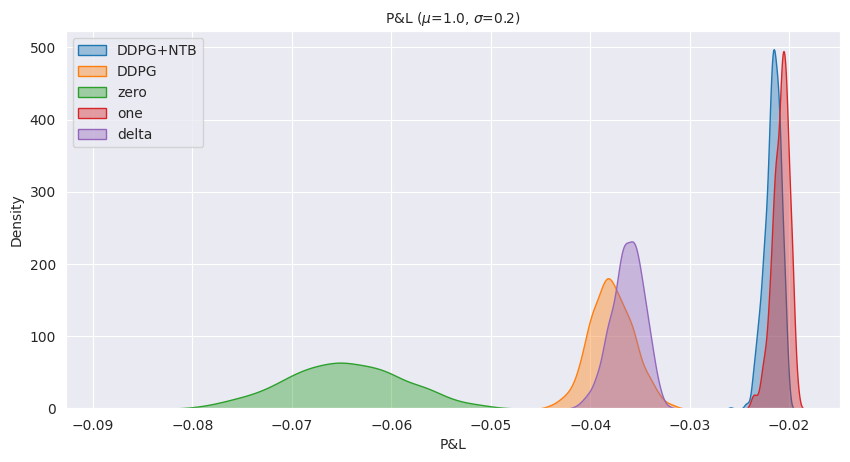

ntb pnl: 		[-0.0217 -0.0217  0.0008]
rl pnl: 		[-0.0379 -0.0379  0.0022]
zero pnl: 		[-0.0648 -0.0647  0.0059]
one pnl: 		[-0.0209 -0.0209  0.0008]
random pnl: 		[-0.2447 -0.2446  0.0048]
delta pnl: 		[-0.0363 -0.0363  0.0016]

ntb cvar:		0.02356
rl cvar:		0.04231
zero cvar:		0.07675
one cvar:		0.02292
random cvar:		0.25520
delta cvar:		0.03991



In [ ]:
sb_kwargs = {'shade': True,
              'alpha': 0.4,
            #  'clip': (-0.04, -0.02)
             }

plt.title(rf'P&L ($\mu$={eval_env.drift}, $\sigma$={eval_env.volatility})')
plt.xlabel(rf'P&L')
if ntb_mode:
    sb.kdeplot(ntb_pnl,**sb_kwargs, label='DDPG+NTB')
sb.kdeplot(rl_pnl, **sb_kwargs, label='DDPG')
sb.kdeplot(zero_pnl,**sb_kwargs, label='zero')
sb.kdeplot(one_pnl,**sb_kwargs, label='one')
# sb.kdeplot(random_pnl,**sb_kwargs, label='random')
sb.kdeplot(delta_pnl,**sb_kwargs, label='delta')
plt.legend(loc=2)
plt.show()

if ntb_mode:
    print(f'ntb pnl: \t\t{np.round(pnl_reward(ntb_pnl), 4)}')
print(f'rl pnl: \t\t{np.round(pnl_reward(rl_pnl), 4)}')
print(f'zero pnl: \t\t{np.round(pnl_reward(zero_pnl), 4)}')
print(f'one pnl: \t\t{np.round(pnl_reward(one_pnl), 4)}')
print(f'random pnl: \t\t{np.round(pnl_reward(random_pnl), 4)}')
print(f'delta pnl: \t\t{np.round(pnl_reward(delta_pnl), 4)}')
print()

if ntb_mode:
    print(f'ntb cvar:\t\t{cvar(ntb_pnl):.5f}')
print(f'rl cvar:\t\t{cvar(rl_pnl):.5f}')
print(f'zero cvar:\t\t{cvar(zero_pnl):.5f}')
print(f'one cvar:\t\t{cvar(one_pnl):.5f}')
print(f'random cvar:\t\t{cvar(random_pnl):.5f}')
print(f'delta cvar:\t\t{cvar(delta_pnl):.5f}')
print()

### 3.4.2 TensorBoard

## 3.5 Save, Load P&L

### 3.5.1 Save

In [ ]:
if not ntb_mode:
    if random_drift:
        rl_pnls = []
        for i in range(5):
            eval_env.drift = 0.25 * i
            eval_env.volatility = 0.2
            # eval_env.volatility = 0.2 + 0.2*i
            print(eval_env.drift, eval_env.volatility)
            rl_pnls.append(eval_env.eval(model, 'pnl', 50))

    elif random_vol:
        rl_pnls_vol = []
        for i in range(5):
            eval_env.drift = 0.0
            eval_env.volatility = 0.2 + 0.2*i
            print(eval_env.drift, eval_env.volatility)
            rl_pnls_vol.append(eval_env.eval(model, 'pnl', 50))

else:
    if random_drift:
        ntb_pnls = []
        for i in range(5):
            eval_env.drift = 0.25 * i
            eval_env.volatility = 0.2
            # eval_env.volatility = 0.2 + 0.2*i
            print(eval_env.drift, eval_env.volatility)
            ntb_pnls.append(eval_env.eval(model, 'pnl', 50))

    if random_vol:
        ntb_pnls_vol = []
        for i in range(5):
            eval_env.drift = 0.0
            eval_env.volatility = 0.2 + 0.2*i
            print(eval_env.drift, eval_env.volatility)
            ntb_pnls_vol.append(eval_env.eval(model, 'pnl', 50))

In [ ]:
sb_kwargs = {'shade': True,
              'alpha': 0.4,
            #  'clip': (-0.04, -0.02)
             }

# plt.title(rf'P&L Result of DDPG ($\mu$={eval_env.drift})')
plt.title(rf'P&L Result of DDPG ($\sigma$={0.2})')
plt.xlabel(rf'P&L')

for i in range(5):
    sb.kdeplot(rl_pnls[i], **sb_kwargs, label=rf'$\mu$={0.5*i}')
    # sb.kdeplot(rl_pnls[i], **sb_kwargs, label=rf'$\sigma$={0.2+0.2*i:.1f}')
    print(np.round(pnl_reward(rl_pnls[i]), 4))

plt.legend()
plt.show()

"""
[-0.0004 -0.0001  0.0123]
[-0.0324 -0.0322  0.0136]
[-0.0683 -0.068   0.0152]
[-0.1075 -0.1072  0.0161]
[-0.149  -0.1486  0.017 ]
"""

In [ ]:
sb_kwargs = {'shade': True,
              'alpha': 0.4,
            #  'clip': (-0.04, -0.02)
             }

plt.title(rf'P&L Result of DDPG ($\mu$={0.0})')
plt.xlabel(rf'P&L')

for i in range(5):
    sb.kdeplot(rl_pnls_vol[i], **sb_kwargs, label=rf'$\sigma$={0.2*i+0.2:.1f}')
    print(np.round(pnl_reward(rl_pnls_vol[i]), 4))

plt.legend()
plt.show()

"""
[-0.0004 -0.0001  0.0123]
[-0.0002  0.0003  0.0249]
[-0.0004  0.0004  0.0389]
[-0.002  -0.001   0.0527]
[-0.0036 -0.0022  0.0679]
"""

In [ ]:
sb_kwargs = {'shade': True,
              'alpha': 0.4,
            #  'clip': (-0.04, -0.02)
             }

# plt.title(rf'P&L Result of NTB ($\mu$={eval_env.drift})')
plt.title(rf'P&L Result of NTB ($\sigma$={0.2})')
plt.xlabel(rf'P&L')

for i in range(5):
    sb.kdeplot(ntb_pnls[i], **sb_kwargs, label=rf'$\mu$={0.5*i}')
    # sb.kdeplot(ntb_pnls[i], **sb_kwargs, label=rf'$\sigma$={0.2+0.2*i:.1f}')
    print(np.round(pnl_reward(ntb_pnls[i]), 4))

plt.legend()
plt.show()

"""
[-0.0168 -0.0168  0.0021]
[-0.0146 -0.0146  0.0017]
[-0.0139 -0.0138  0.0013]
[-0.014 -0.014  0.001]
[-0.0149 -0.0149  0.0009]
"""

In [ ]:
sb_kwargs = {'shade': True,
              'alpha': 0.4,
            #  'clip': (-0.04, -0.02)
             }

plt.title(rf'P&L Result of NTB ($\mu$={0.0})')
plt.xlabel(rf'P&L')

for i in range(5):
    # sb.kdeplot(ntb_pnls[i], **sb_kwargs, label=rf'$\mu$={0.5*i}')
    sb.kdeplot(ntb_pnls_vol[i], **sb_kwargs, label=rf'$\sigma$={0.2+0.2*i:.1f}')
    print(np.round(pnl_reward(ntb_pnls_vol[i]), 4))

plt.legend()
"""
[-0.0002 -0.0001  0.0049]
[0.     0.0002 0.0101]
[-0.0001  0.0003  0.0158]
[-0.0007 -0.0003  0.0219]
[-0.0013 -0.0008  0.0285]
"""

In [ ]:
# xrange = np.arange(0.2, 1.2, 0.2)
xrange = np.arange(0.0, 1.2, 0.25)

# plt.title(rf'Mean of P&L ($\mu$={eval_env.drift})')
plt.title(rf'Mean of P&L ($\sigma$={0.2})')
plt.plot(xrange, list(map(np.mean, rl_pnls)), 'o-', label='DDPG')
plt.plot(xrange, list(map(np.mean, ntb_pnls)), 'o-', label='NTB')
# plt.xlabel('volatility')
plt.xlabel('drift')
plt.xticks(xrange)
plt.legend()
plt.show()

In [ ]:
# xrange = np.arange(0.2, 1.2, 0.2)
xrange = np.arange(0.0, 1.2, 0.25)

# plt.title(rf'CVaR(95%) of P&L ($\mu$={eval_env.drift})')
plt.title(rf'CVaR(95%) of P&L ($\sigma$={0.2})')
plt.plot(xrange, list(map(cvar, rl_pnls)), 'o-', label='DDPG')
plt.plot(xrange, list(map(cvar, ntb_pnls)), 'o-', label='NTB')
# plt.xlabel('volatility')
plt.xlabel('drift')
plt.xticks(xrange)
plt.legend()
plt.show()

In [ ]:
xrange = np.arange(0.0, 1.2, 0.25)

# plt.title(rf'Mean of P&L ($\mu$={eval_env.drift})')
plt.title(rf'Mean of P&L ($\mu$={0.0})')
plt.plot(xrange, list(map(np.mean, rl_pnls_vol)), 'o-', label='DDPG')
plt.plot(xrange, list(map(np.mean, ntb_pnls_vol)), 'o-', label='NTB')
# plt.xlabel('volatility')
plt.xlabel('volatility')
plt.xticks(xrange)
plt.legend()
plt.show()

In [ ]:
xrange = np.arange(0.2, 1.2, 0.2)

plt.title(rf'CVaR(95%) of P&L ($\mu$={0.0})')
plt.plot(xrange, list(map(cvar, rl_pnls_vol)), 'o-', label='DDPG')
plt.plot(xrange, list(map(cvar, ntb_pnls_vol)), 'o-', label='NTB')
plt.xlabel('volatility')
# plt.xlabel('drift')
plt.xticks(xrange)
plt.legend()